In [46]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import json
sns.set()

from tardis_dev import datasets, get_exchange_details

import nest_asyncio
nest_asyncio.apply()

# exchange data info
# https://api.tardis.dev/v1/exchanges/binance

In [159]:
class TardisLoader:
    def __init__(self, root_dir: str, api_key: str):
        self._root_dir = root_dir
        self._api_key = api_key

    def load(self, start, end, data_type, exchange, symbol):
        datasets.download(
            exchange=exchange,
            data_types=[data_type],
            from_date=str(start),
            to_date=str(end + timedelta(days=1)),
            symbols=[symbol],
            download_dir=f"{self._root_dir}/{data_type}-{exchange}_{symbol}",
            api_key=self._api_key
        )
        
        def path(date: str, data_type: str, exchange: str, symbol: str) -> str:
            return \
                f"{self._root_dir}/{data_type}-{exchange}_{symbol}" \
                f"/{exchange}_{data_type}_{date}_{symbol}.csv.gz"

        df = pd.concat([
            pd.read_csv(path(str(d.date()), data_type, exchange, symbol))
            for d in pd.date_range(start, end)
        ]).reset_index(drop=True)
        df.index = pd.to_datetime(df["timestamp"], unit="us", utc=True)

        return df.sort_index()

In [170]:
root_dir = './Data'
api_key = 'TD.sSGNjEpohBl9i0FV.zz0-s-b6DZ9c2lt.uoNpgBPGaTITrA9.YlW26JKS0PSfoOG.2pEnnkHAnTpOloD.3wMo'

# with open('format_cfg.json') as format_cfg:
#     api_format = json.load(format_cfg)
    
Tardis_data = TardisLoader(root_dir, api_key)

In [172]:
api_format

{'binance': {'spot': {'exchange': 'binance', 'symbol': 'usdt'},
  'perp': {'exchange': 'binance-futures', 'symbol': 'usdt'}},
 'bybit': {'spot': {'exchange': 'bybit-spot', 'symbol': 'usdt'},
  'perp': {'exchange': 'bybit', 'symbol': 'usdt'}},
 'okx': {'spot': {'exchange': 'okex', 'symbol': '-usdt'},
  'perp': {'exchange': 'okex-swap', 'symbol': '-usdt-swap'}},
 'huobi': {'spot': {'exchange': 'huobi', 'symbol': 'usdt'},
  'perp': {'exchange': 'huobi-dm-linear-swap', 'symbol': '-usdt'}},
 'gate': {'spot': {'exchange': 'gate-io', 'symbol': '_usdt'},
  'perp': {'exchange': 'gate-io-futures', 'symbol': '_usdt'}}}

### Load data

In [176]:
start_time = datetime.strptime("2024-06-02", "%Y-%m-%d")
end_time = datetime.strptime("2024-06-03", "%Y-%m-%d")

# Load the spot trades data
btc_trade_binance = Tardis_data.load(start_time, end_time, data_type='trades', exchange='binance', symbol='btcusdt')
btc_trade_bybit = Tardis_data.load(start_time, end_time, data_type='trades', exchange='bybit-spot', symbol='btcusdt')
btc_trade_okex = Tardis_data.load(start_time, end_time, data_type='trades', exchange='okex', symbol='BTC-USDT')

# Load the spot quotes data (BBO)
btc_quote_binance = Tardis_data.load(start_time, end_time, data_type='quotes', exchange='binance', symbol='btcusdt')
btc_quote_bybit = Tardis_data.load(start_time, end_time, data_type='quotes', exchange='bybit-spot', symbol='btcusdt')
btc_quote_okex = Tardis_data.load(start_time, end_time, data_type='quotes', exchange='okex', symbol='BTC-USDT')

# Load the perp trades data
btc_trade_binance_p = Tardis_data.load(start_time, end_time, data_type='trades', exchange='binance-futures', symbol='btcusdt')
btc_trade_bybit_p = Tardis_data.load(start_time, end_time, data_type='trades', exchange='bybit', symbol='btcusdt')
btc_trade_okex_p = Tardis_data.load(start_time, end_time, data_type='trades', exchange='okex-swap', symbol='btc-usdt-swap')

# Load the perp trades data
eth_trade_binance_p = Tardis_data.load(start_time, end_time, data_type='trades', exchange='binance-futures', symbol='ethusdt')
eth_trade_bybit_p = Tardis_data.load(start_time, end_time, data_type='trades', exchange='bybit', symbol='ethusdt')
eth_trade_okex_p = Tardis_data.load(start_time, end_time, data_type='trades', exchange='okex-swap', symbol='eth-usdt-swap')

### Package Distribution

In [208]:
spot_trades_btc = [btc_trade_binance, btc_trade_bybit, btc_trade_okex]
spot_quotes_btc = [btc_quote_binance, btc_quote_bybit, btc_quote_okex]
perp_trades_btc = [btc_trade_binance_p, btc_trade_bybit_p, btc_trade_okex_p]
perp_trades_eth = [eth_trade_binance_p, eth_trade_bybit_p, eth_trade_okex_p]

agg_group_1 = spot_trades_btc
agg_group_2 = spot_trades_btc + spot_quotes_btc
agg_group_3 = spot_trades_btc + perp_trades_btc
agg_group_4 = spot_trades_btc + perp_trades_btc + perp_trades_eth
agg_group_5 = [btc_quote_binance]
agg_group_6 = [btc_trade_binance_p]

In [212]:
pd.concat(agg_group_5).reset_index(drop=True).sort_values(by='timestamp').head(50)

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount
0,binance,BTCUSDT,1717286401256000,1717286401258081,6.06253,67766.85,67766.84,2.66804
1,binance,BTCUSDT,1717286401258081,1717286401258081,6.06313,67766.85,67766.84,2.66804
2,binance,BTCUSDT,1717286401456000,1717286401460307,5.22872,67766.85,67766.84,3.26181
3,binance,BTCUSDT,1717286401556000,1717286401568186,5.22733,67766.85,67766.84,3.26191
4,binance,BTCUSDT,1717286401656000,1717286401660087,5.55552,67766.85,67766.84,3.26191
5,binance,BTCUSDT,1717286401756000,1717286401760058,5.55497,67766.85,67766.84,3.26191
6,binance,BTCUSDT,1717286401956000,1717286401958289,5.55465,67766.85,67766.84,3.26191
7,binance,BTCUSDT,1717286402156000,1717286402158565,5.55318,67766.85,67766.84,3.26172
8,binance,BTCUSDT,1717286402256000,1717286402259784,5.55211,67766.85,67766.84,3.26210
9,binance,BTCUSDT,1717286402456000,1717286402458499,5.54948,67766.85,67766.84,3.26210


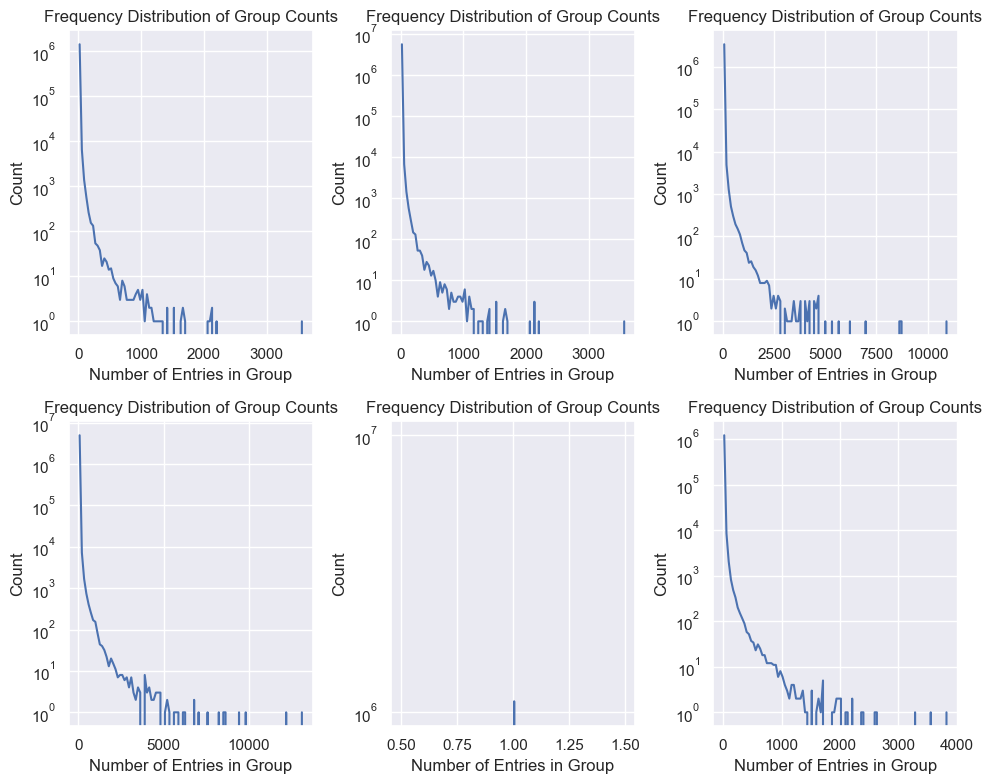

In [210]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

axs = axs.flatten()
groups = [agg_group_1, agg_group_2, agg_group_3, agg_group_4, agg_group_5, agg_group_6]

for i, group in enumerate(groups):
    agg_data = pd.concat(group).reset_index(drop=True).sort_values(by='timestamp')
    agg_data['timestamp_diff'] = agg_data['timestamp'].diff()
    agg_data['group'] = (agg_data['timestamp_diff'] > 1e3).cumsum()
    group_counts = agg_data.groupby('group').size().reset_index(name='count')
    
    counts, bin_edges = np.histogram(group_counts['count'], bins=100)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    axs[i].plot(bin_centers, counts, label='Frequency Curve')
    axs[i].set_yscale('log')  # Set y-axis to log scale if needed
    axs[i].set_title('Frequency Distribution of Group Counts')
    axs[i].set_xlabel('Number of Entries in Group')
    axs[i].set_ylabel('Count')
    plt.grid(True)

# Adjust the layout
plt.tight_layout()
plt.show()

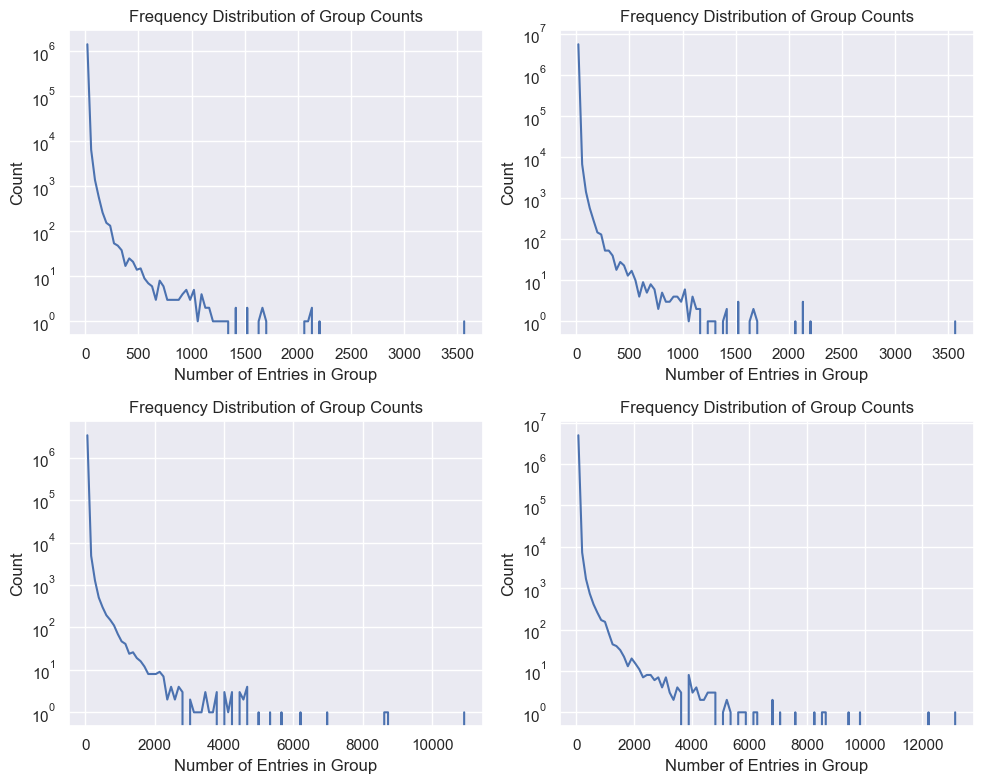

In [192]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

axs = axs.flatten()
groups = [agg_group_1, agg_group_2, agg_group_3, agg_group_4, agg_group_5]

for i, group in enumerate(groups):
    agg_data = pd.concat(group).reset_index(drop=True).sort_values(by='timestamp')
    agg_data['timestamp_diff'] = agg_data['timestamp'].diff()
    agg_data['group'] = (agg_data['timestamp_diff'] > 1e3).cumsum()
    group_counts = agg_data.groupby('group').size().reset_index(name='count')
    
    counts, bin_edges = np.histogram(group_counts['count'], bins=100)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    axs[i].plot(bin_centers, counts, label='Frequency Curve')
    axs[i].set_yscale('log')  # Set y-axis to log scale if needed
    axs[i].set_title('Frequency Distribution of Group Counts')
    axs[i].set_xlabel('Number of Entries in Group')
    axs[i].set_ylabel('Count')
    plt.grid(True)

# Adjust the layout
plt.tight_layout()
plt.show()

In [214]:
# Todo, 弄清楚Cluster之后的时间间隔是否会造成拥堵 
# 1. 可以先看平均两个packet之间的间隔是多长, 以及中位数, 做到这点其实就是先define packet, 然后计算packet之间的间隔
# 2. 或者先假设处理每一个信息需要多长时间, 然后处理一个cluster的数据需要多长时间, 然后后面有多少个数据会受到影响
# 3. 目的就是看拥堵的情况

In [195]:
btc_quote_binance.head(5)

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount
timestamp,,,,,,,,
2024-06-02 00:00:01.256000+00:00,binance,BTCUSDT,1717286401256000,1717286401258081,6.06253,67766.85,67766.84,2.66804
2024-06-02 00:00:01.258081+00:00,binance,BTCUSDT,1717286401258081,1717286401258081,6.06313,67766.85,67766.84,2.66804
2024-06-02 00:00:01.456000+00:00,binance,BTCUSDT,1717286401456000,1717286401460307,5.22872,67766.85,67766.84,3.26181
2024-06-02 00:00:01.556000+00:00,binance,BTCUSDT,1717286401556000,1717286401568186,5.22733,67766.85,67766.84,3.26191
2024-06-02 00:00:01.656000+00:00,binance,BTCUSDT,1717286401656000,1717286401660087,5.55552,67766.85,67766.84,3.26191


In [197]:
btc_trade_binance.head(5)

,exchange,symbol,timestamp,local_timestamp,id,side,price,amount
timestamp,,,,,,,,
2024-06-02 00:00:00.355000+00:00,binance,BTCUSDT,1717286400355000,1717286400360071,3621628241,sell,67766.84,0.00738
2024-06-02 00:00:00.418000+00:00,binance,BTCUSDT,1717286400418000,1717286400421259,3621628242,buy,67766.85,0.00013
2024-06-02 00:00:00.458000+00:00,binance,BTCUSDT,1717286400458000,1717286400460646,3621628243,buy,67766.85,0.00117
2024-06-02 00:00:00.717000+00:00,binance,BTCUSDT,1717286400717000,1717286400719955,3621628244,sell,67766.84,0.00025
2024-06-02 00:00:01.002000+00:00,binance,BTCUSDT,1717286401002000,1717286401005168,3621628245,buy,67766.85,0.00016


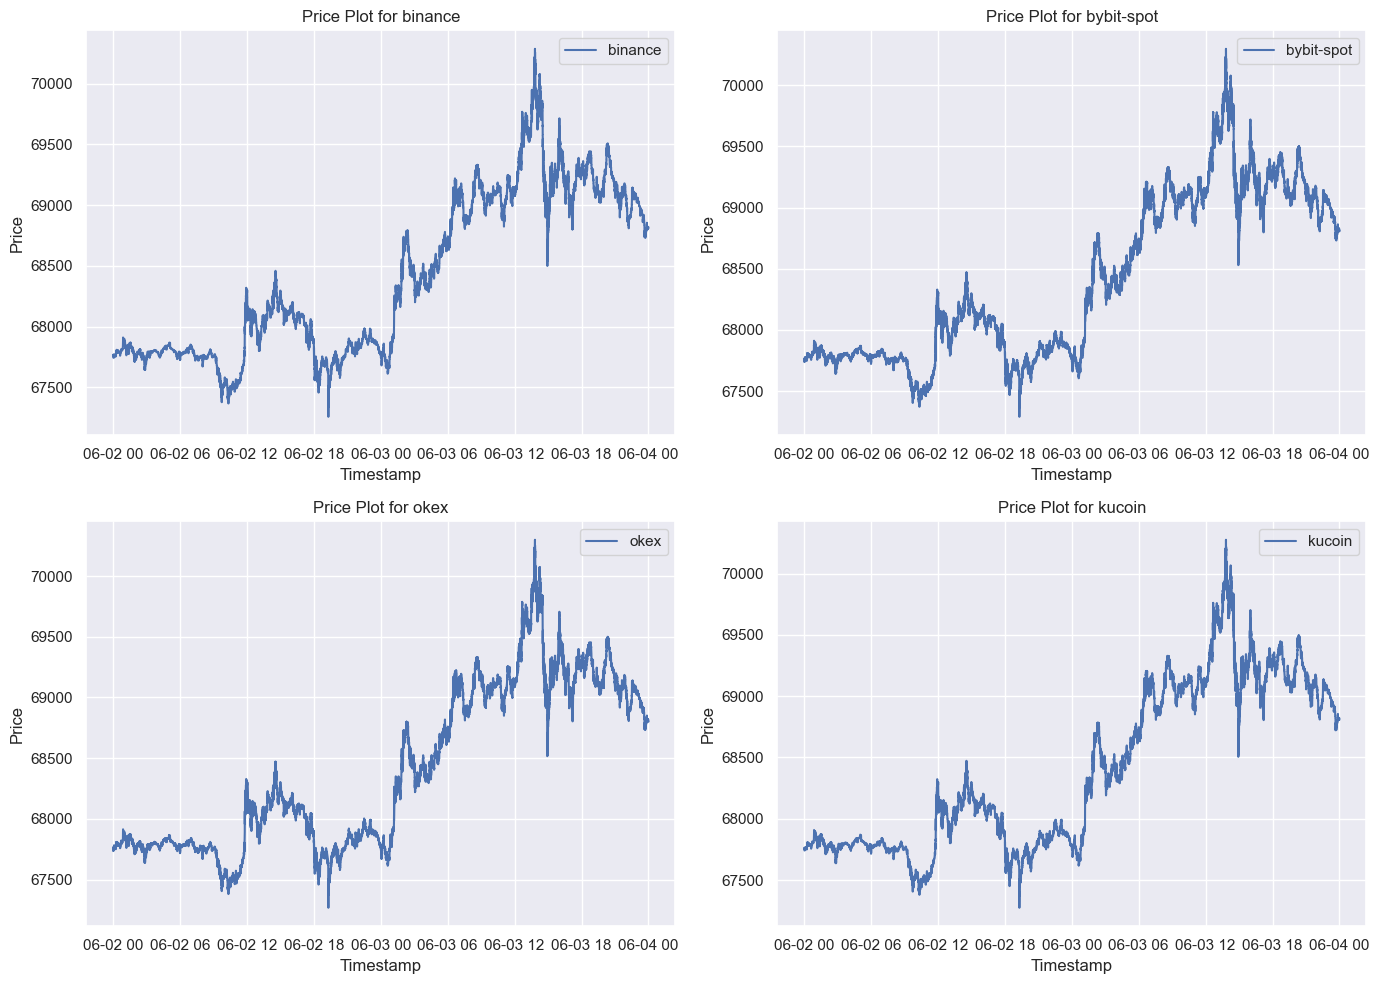

In [201]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs = axs.flatten()

trades = [btc_trade_binance, btc_trade_bybit, btc_trade_okex, btc_trade_kucoin]

for i, df in enumerate(trades):
    exchange = df['exchange'].iloc[0]
    axs[i].plot(df['price'], label=exchange)
    axs[i].set_title(f'Price Plot for {exchange}')
    axs[i].set_xlabel('Timestamp')
    axs[i].set_ylabel('Price')
    axs[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

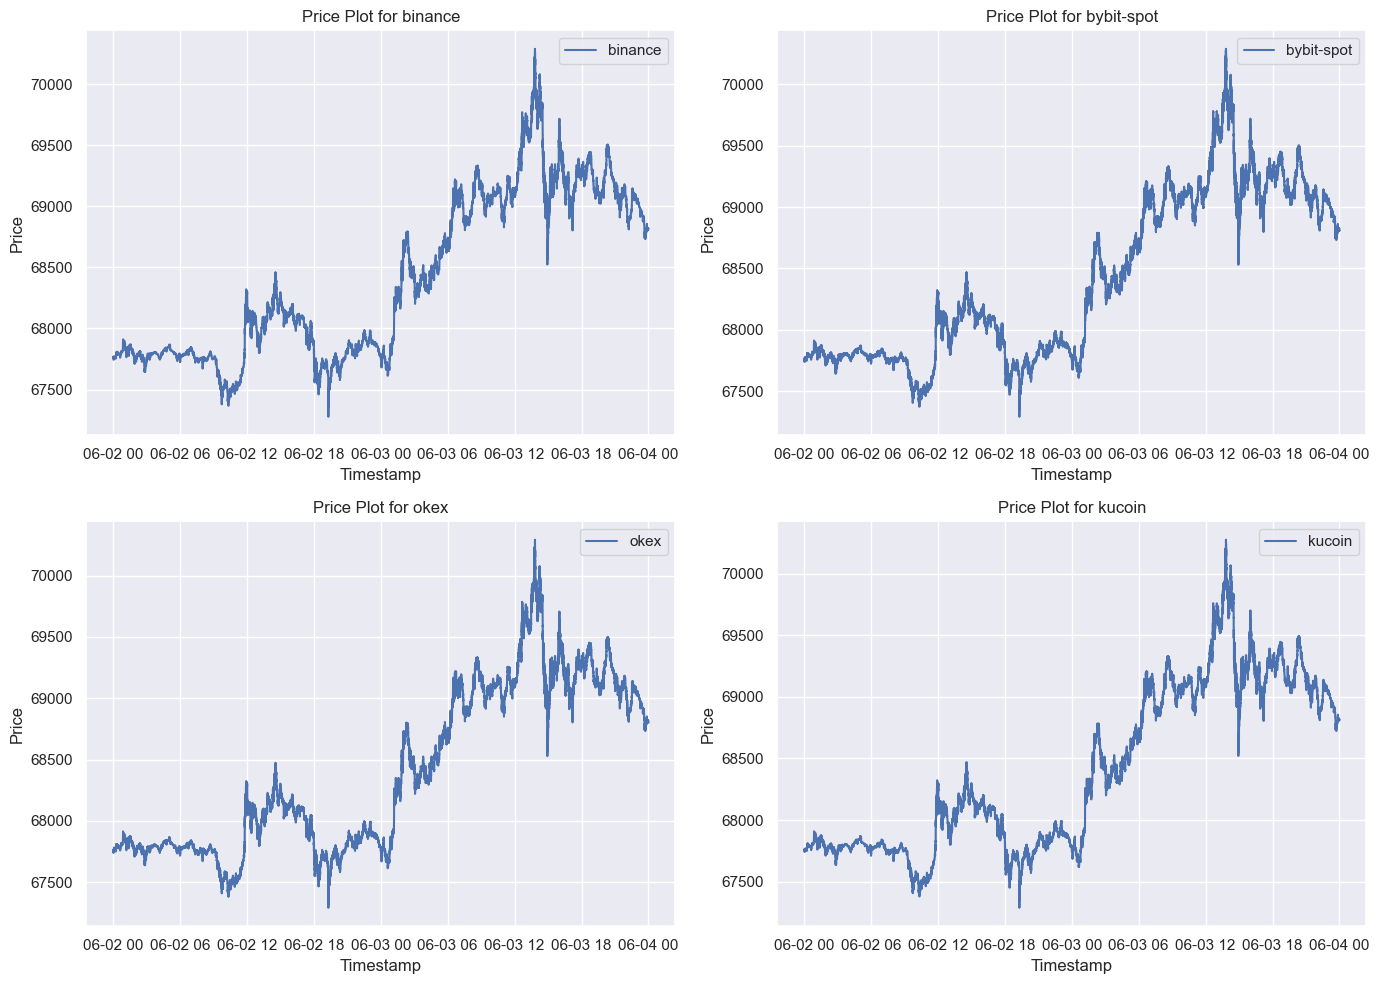

In [203]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs = axs.flatten()

quotes = [btc_quote_binance, btc_quote_bybit, btc_quote_okex, btc_quote_kucoin]

for i, df in enumerate(quotes):
    mid_price = (df['bid_price'] + df['ask_price'])/2
    exchange = df['exchange'].iloc[0]
    axs[i].plot(mid_price, label=exchange)
    axs[i].set_title(f'Price Plot for {exchange}')
    axs[i].set_xlabel('Timestamp')
    axs[i].set_ylabel('Price')
    axs[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
# Mid Price


# Micro Price


# Valia Price


# EMA Price

